In [2]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
import keras.backend as K

from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical

from scipy.stats import norm

/Users/xiaolin/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
train = np.load("resources/data/nab/nab_machine_temperature/train.npy")
validation = np.load("resources/data/nab/nab_machine_temperature/validation.npy")
test = np.load("resources/data/nab/nab_machine_temperature/test.npy")

# preprocessing
mean_x = np.mean(train[:,0])
std_x = np.std(train[:,0])

test_labels = test[:,1]

train = (train[:,0] - mean_x)/std_x
validation = (validation[:,0] - mean_x)/std_x
test = (test[:,0] - mean_x)/std_x


In [4]:
def prepare_seq2seq_data(dataset, look_back, look_ahead):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - look_ahead):
        input_seq = dataset[i:(i + look_back)]
        output_seq = dataset[i + look_back:(i + look_back + look_ahead)]
        dataX.append(input_seq)
        dataY.append(output_seq)
    dataX = np.reshape(np.array(dataX),[-1,look_back,1])
    dataY = np.reshape(np.array(dataY),[-1,look_ahead,1])
    return dataX, dataY

look_back = 24
look_ahead = 1

X_train, y_train = prepare_seq2seq_data(train,look_back,look_ahead)
X_validation, y_validation =  prepare_seq2seq_data(validation,look_back,look_ahead)
X_test, y_test = prepare_seq2seq_data(test,look_back,look_ahead)
X_test_labels,y_test_labels = prepare_seq2seq_data(test_labels,look_back,look_ahead)

# 1 step look ahead
y_train = y_train.reshape(len(y_train),1)
y_validation = y_validation.reshape(len(y_validation),1)
y_test = y_test.reshape(len(y_test),1)

In [8]:
def model(input_shape, droprate = 0.2):
    X_input = Input(shape = input_shape)
    X = LSTM(units = 80, dropout = droprate, recurrent_dropout = droprate, return_sequences=True)(X_input)
    X = LSTM(units = 20, dropout = droprate, recurrent_dropout = droprate, return_sequences=False)(X)
    X = Dropout(droprate)(X)
    X = Dense(1, activation='linear')(X)
    
    model = Model(inputs = X_input, outputs = X)
    return model

lstm = model((look_back,look_ahead))
lstm.summary()
lstm.compile(loss='mse',
             optimizer='adam',
             metrics=['mse'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 24, 1)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 24, 80)            26240     
_________________________________________________________________
lstm_6 (LSTM)                (None, 20)                8080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 34,341
Trainable params: 34,341
Non-trainable params: 0
_________________________________________________________________


In [9]:
filepath="lstm.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

lstm.fit(X_train, y_train,
         epochs= 50,
         batch_size= 1024, shuffle = True, validation_data= (X_validation, y_validation),callbacks=callbacks_list)

Train on 8051 samples, validate on 2279 samples
Epoch 1/50
8051/8051 [==============================] - 4s - loss: 0.6690 - mean_squared_error: 0.6690 - val_loss: 0.2326 - val_mean_squared_error: 0.2326
Epoch 2/50
8051/8051 [==============================] - 4s - loss: 0.3858 - mean_squared_error: 0.3858 - val_loss: 0.1686 - val_mean_squared_error: 0.1686
Epoch 3/50
8051/8051 [==============================] - 4s - loss: 0.3431 - mean_squared_error: 0.3431 - val_loss: 0.1264 - val_mean_squared_error: 0.1264
Epoch 4/50
8051/8051 [==============================] - 4s - loss: 0.3257 - mean_squared_error: 0.3257 - val_loss: 0.1111 - val_mean_squared_error: 0.1111
Epoch 5/50
8051/8051 [==============================] - 4s - loss: 0.2869 - mean_squared_error: 0.2869 - val_loss: 0.0755 - val_mean_squared_error: 0.0755
Epoch 6/50
8051/8051 [==============================] - 4s - loss: 0.2750 - mean_squared_error: 0.2750 - val_loss: 0.0773 - val_mean_squared_error: 0.0773
Epoch 7/50
8051/8051 [

8051/8051 [==============================] - 4s - loss: 0.0915 - mean_squared_error: 0.0915 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 28/50
8051/8051 [==============================] - 4s - loss: 0.0892 - mean_squared_error: 0.0892 - val_loss: 0.0360 - val_mean_squared_error: 0.0360
Epoch 29/50
8051/8051 [==============================] - 4s - loss: 0.0847 - mean_squared_error: 0.0847 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 30/50
8051/8051 [==============================] - 4s - loss: 0.0912 - mean_squared_error: 0.0912 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 31/50
8051/8051 [==============================] - 4s - loss: 0.0806 - mean_squared_error: 0.0806 - val_loss: 0.0354 - val_mean_squared_error: 0.0354
Epoch 32/50
8051/8051 [==============================] - 4s - loss: 0.0851 - mean_squared_error: 0.0851 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 33/50
8051/8051 [==============================] - 4s - loss: 0.0807 -

In [10]:
lstm.load_weights('lstm.h5')
print 'mse of validation: ', lstm.evaluate(X_validation, y_validation)[0]
print 'mse of training: ', lstm.evaluate(X_train, y_train)[0]
print 'mse of test: ', lstm.evaluate(X_test, y_test)[0]

2279/2279 [==============================] - 1s     
 0.028395013052507575
8051/8051 [==============================] - 5s     
 0.03355287116482704
7328/7361 [============================>.] - ETA: 0s 0.4348265001677597


In [11]:
# MC dropout
f = K.function([lstm.layers[0].input, K.learning_phase()],
               [lstm.layers[-1].output])
def predict_with_uncertainty(f, x, n_iter=500):
    result = [0 for i in range(n_iter)]
    for iter in range(n_iter):
        if iter%100 == 0:
            print 'iteration: ', iter
        result[iter] = f((x,1))[0]
        
    return result

pred_test = predict_with_uncertainty(f, X_test, n_iter=500)
pred_validation = predict_with_uncertainty(f, X_validation, n_iter=500)

iteration:  0
iteration:  100
iteration:  200
iteration:  300
iteration:  400
iteration:  0
iteration:  100
iteration:  200
iteration:  300
iteration:  400


In [12]:
pred_validation = np.array(pred_validation).reshape(len(pred_validation), len(pred_validation[0]))
pred_test = np.array(pred_test).reshape(len(pred_test), len(pred_test[0]))

pred_validation = pred_validation*std_x  + mean_x
pred_test = pred_test*std_x + mean_x

np.save('resources/data/nab/nab_machine_temperature/pred_validation.npy',pred_validation)
np.save('resources/data/nab/nab_machine_temperature/pred_test.npy',pred_test)

In [13]:
pred_test_point = lstm.predict(X_test)
pred_test_point = pred_test_point*std_x + mean_x

pred_train_point = lstm.predict(X_train)
pred_train_point = pred_train_point*std_x + mean_x
np.save('resources/data/nab/nab_machine_temperature/pred_train_point.npy',pred_train_point)
np.save('resources/data/nab/nab_machine_temperature/pred_test_point.npy',pred_test_point)

y_test = y_test*std_x + mean_x
y_train = y_train*std_x + mean_x
y_validation = y_validation*std_x + mean_x

## prediction

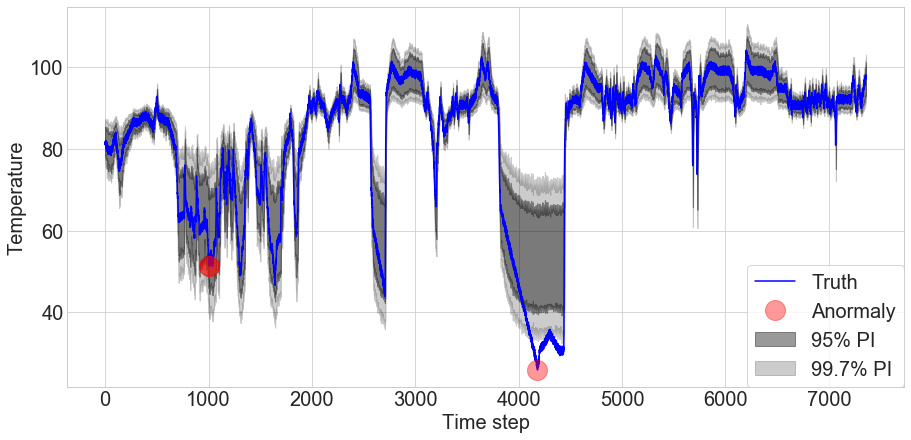

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

def prediction_plot(pred_res, truth, true_anormalies, name = ''):
    pred_mean = np.mean(pred_res, axis = 0)
    pred_std = np.std(pred_res, axis = 0)

    plt.figure(figsize = (15, 7))
    lower1 = pred_mean - 2*pred_std
    upper1 = pred_mean + 2*pred_std 
    
    lower2 = pred_mean - 3*pred_std
    upper2 = pred_mean + 3*pred_std
    
    plt.fill_between(range(len(truth)), lower1, upper1, color ='k', alpha =0.4, label ='95% PI')
    plt.fill_between(range(len(truth)), lower2, upper2, color ='k', alpha =0.2, label ='99.7% PI')
    
    plt.plot(truth, 'b', label='Truth')
    
    for i in range(len(true_anormalies)):
        if i == 0:
            plt.plot(true_anormalies[i], truth[true_anormalies[i]], 'ro', markersize = 20, alpha =0.4, label ='Anormaly')
        plt.plot(true_anormalies[i], truth[true_anormalies[i]], 'ro', markersize = 20, alpha =0.4)

    plt.xlabel('Time step',fontsize=20)
    plt.ylabel('Temperature',fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(bbox_to_anchor=(1, 0),loc="lower right", borderaxespad=0.,frameon=True,prop={'size': 20})
    plt.savefig(name,format='pdf', dpi=300)
    
true_anormalies = np.where(y_test_labels==1)[0]
prediction_plot(pred_test,y_test, true_anormalies, name = 'test_dataset_02.pdf')

## prediction error distribution

In [16]:
error_train = y_train - pred_train_point
me_train = np.mean(error_train)
stde_train = np.std(error_train)

In [17]:
endpoints = [me_train- 3*stde_train, me_train+3*stde_train]
error_test = (y_test - pred_test_point).reshape(len(y_test), )

true_anormalies_test = np.where(y_test_labels==1)[0]
outliers_test = np.where((error_test <endpoints[0]) | (error_test >endpoints[1]))[0]

In [18]:
len(outliers_test)

1033

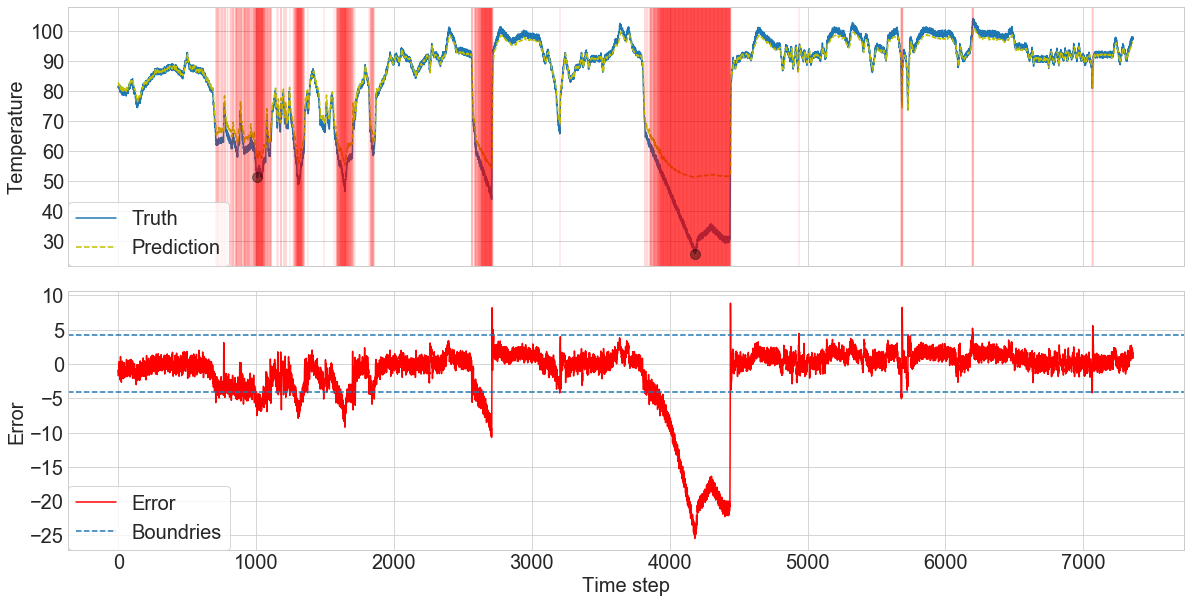

In [19]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.1)
ax1 = plt.subplot(211)
ax1.plot(y_test, label='Truth')
ax1.plot(pred_test_point,ls ='dashed',label='Prediction',color ='y')
#ax1.plot((y_test - pred_test_point),label='Error', color ='r')

for loc in outliers_test:
    ax1.axvline(x=loc,color='r',alpha=.1)

for anormaly in true_anormalies_test:
    ax1.plot(anormaly, y_test[anormaly], 'k.', markersize=20.0, alpha=0.4)

plt.ylabel('Temperature',fontsize=20)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(0, 0),loc="lower left", borderaxespad=0.,frameon=True,prop={'size': 20})


ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(y_test - pred_test_point,label='Error', color ='r')
ax2.axhline(y=endpoints[0],ls='dashed',label='Boundries')
ax2.axhline(y=endpoints[1],ls='dashed')
plt.legend(bbox_to_anchor=(0, 0),loc="lower left", borderaxespad=0.,frameon=True,prop={'size': 20})

xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xlabel("Time step",fontsize=20)
plt.ylabel("Error",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('error_dist_result_02.pdf',format='pdf', dpi=300)

## MC dropout

In [33]:
mean_pred_validation = np.mean(pred_validation,axis=0)
std_pred_validation = np.std(pred_validation, axis=0)
std_max = std_pred_validation.max()

from scipy.stats import norm
p_value_validation = []

for i in range(len(y_validation)):
    cdf = norm.cdf(y_validation[i], loc = mean_pred_validation[i], scale = std_pred_validation[i])
    p_value_validation.append(min(cdf, 1-cdf))

p_value_validation= np.array(p_value_validation).reshape(len(p_value_validation),)
p_value_max = p_value_validation.max()
p_value_II = std_pred_validation/std_max - np.array(p_value_validation)/p_value_max

std_max = std_pred_validation.max()
_,threshold = norm.interval(0.997, loc = p_value_II.mean(), scale = p_value_II.std())

In [34]:
p_value_std = std_pred_validation/std_max
_,threshold_std = norm.interval(0.997, loc = p_value_std.mean(), scale = p_value_std.std())

_,threshold_p_value = norm.interval(0.997, loc = p_value_validation.mean(), scale = p_value_validation.std())

In [35]:
mean_pred_test = np.mean(pred_test,axis=0)
std_pred_test = np.std(pred_test, axis=0)

outliers_test = []

pred_test = np.sort(pred_test,axis=0)

p_value_test = []

for i in range(len(y_test)):
    cdf = norm.cdf(y_test[i], loc = mean_pred_test[i], scale = std_pred_test[i])
    p_value_test.append(min(cdf, 1-cdf))

p_value_test= np.array(p_value_test).reshape(len(p_value_test),)
p_value_II = std_pred_test/std_max - p_value_test/p_value_max

for i in range(len(y_test)): 
    if p_value_II[i] > threshold:
        outliers_test.append(i)
    
true_anormalies_test = np.where(y_test_labels==1)[0]

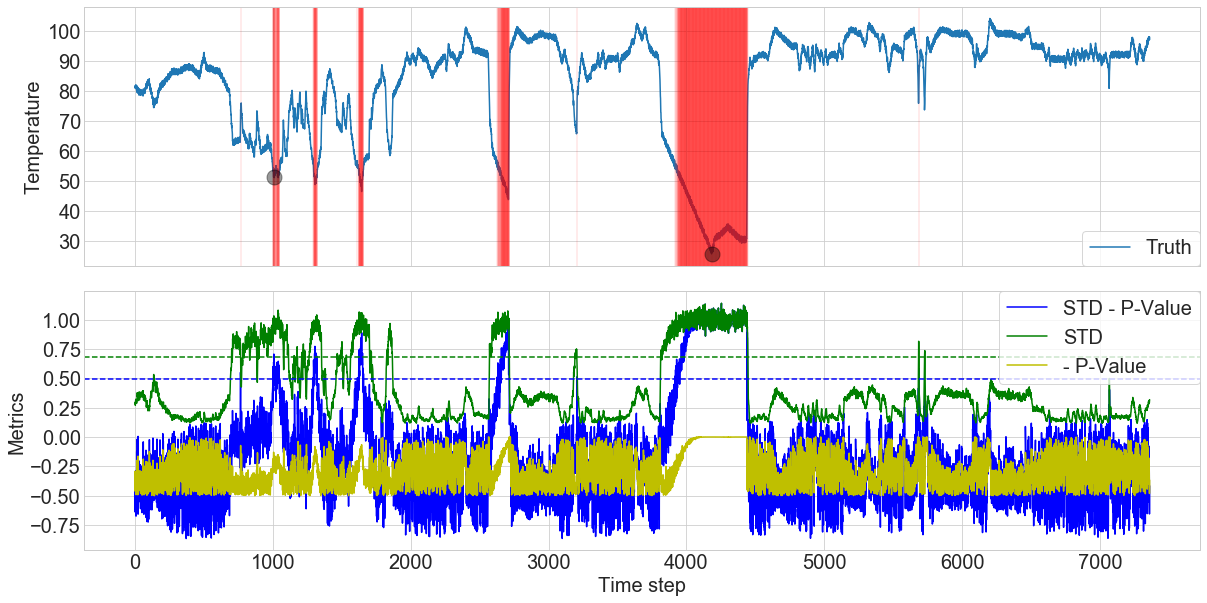

In [38]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.1)
ax1 = plt.subplot(211)
ax1.plot(y_test, label='Truth')
for loc in outliers_test:
    ax1.axvline(x=loc,color='r',alpha=0.1)

for anormaly in true_anormalies_test:
    ax1.plot(anormaly, y_test[anormaly], 'k.', markersize=30, alpha=0.4)

plt.ylabel('Temperature',fontsize=20)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1, 0),loc="lower right", borderaxespad=0.,frameon=True,prop={'size': 20})

ax2 = plt.subplot(212)
ax2.plot(p_value_II, label = 'STD - P-Value', color = 'b')
ax2.plot(std_pred_test/std_max, label = 'STD', color = 'g')
ax2.plot(-p_value_test, label = '- P-Value', color = 'y')

ax2.axhline(y=threshold,ls='dashed', color = 'b')
ax2.axhline(y=threshold_std,ls='dashed', color = 'g')

plt.legend(bbox_to_anchor=(1, 1),loc="upper right", borderaxespad=0.,frameon=True,prop={'size': 20})

xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)

plt.xlabel("Time step",fontsize=20)
plt.ylabel("Metrics",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('MC_dropout_results_02.pdf',format='pdf', dpi=300)

In [72]:
len(y_test)/20

368